## Example: Build a Product Development Score Regression Model
NewCo Inc. is in the process of developing a new food product formulation. The quality of the product is evaluated based on 7200 features such as taste, mouthfeel, storage life, acidity, etc. The company has conducted tests on 100 different product formulations and has manually assessed the overall quality of these formulations.
* NewCo Inc. aims to replace the expensive manual testing with an automated system that can predict a product quality score using a combination of the 7200 feature scores, which is inexpensive relative to manual testing.
* The company is seeking the development of a linear regression model that can estimate the overall product score based on the feature scores.

## Setup
This example requires several external libraries and a function to compute the outer product. Let's download and install these packages and call our `Include.jl` file.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-10/L10a`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-10/L10a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-10/L10a/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-10/L10a/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-4800-5800-Examples-AY-2024/week-10/L10a/Manifest.toml`


## Prerequisites 
Let's load the `data matrix` $\mathbf{X}$ (which holds the measurements) and the output vector $\mathbf{Y}$ (which holds the product scores) using the `load datafiles (...)` function.
* The `data matrix` $\mathbf{X}$ is a `100` $\times$ `7200` array, where the rows hold a product formulation, and the columns hold the feature scores.
* The `output vector` $\mathbf{Y}$ is a `100`$\times$ `1` column vector which holds the overall score for formulation $i$.

In [2]:
y = loaddatafiles(joinpath(_PATH_TO_DATA, "score.csv"));
X = loaddatafiles(joinpath(_PATH_TO_DATA, "sample.csv"));

In [23]:
X

100×7200 Matrix{Float64}:
  4.08  -6.17   6.84  -3.79   1.31  …  -2.91   4.85  -0.29   4.17   0.44
 -0.29  -3.54   3.16  -3.54   1.8      -1.89   3.83  -0.29   4.17   7.43
  6.36   0.44   9.17  -9.42   2.57     -2.86   4.13  -0.29   9.03   9.08
  4.37  -8.5   -6.21  -6.89  -2.38     -1.99  -5.53  -0.29  -0.29   2.33
 -2.38  -7.09  -8.16  -8.74   0.73     -7.52   2.14  -1.84   2.04   3.2
 -9.66  -4.32  -1.7   -0.29   0.73  …  -4.66  -4.66   0.1    3.79   6.75
 -0.73  -8.69   9.27  -5.29  -0.97     -7.52   0.1   -3.01   7.86  -8.79
 -5.34  -0.87   1.41  -8.93   5.0       6.02  -1.75  -0.29  -7.86  -0.53
  8.88  -6.65  -5.19  -7.86  -7.23     -3.83   0.44   0.49   4.17  -8.74
  9.22  -1.8   -4.42  -1.6   -1.36     -4.42   0.39  -0.29   5.73   7.23
  6.75  -6.8    8.2   -2.91   3.83  …  -4.81  -5.34   1.26  -0.29  -0.53
  8.64  -5.73  -7.86  -0.29   1.75     -2.14   6.21   0.49   3.2    5.63
  4.42  -5.0   -6.94  -4.85   5.63     -0.97  -6.89  -0.29  -9.61  -7.14
  ⋮                       

Finally, let's partition the data into a `training` and `testing` set so that we can determine how well the model can predict unseen data, i.e., how well the model `generalizes`.

In [3]:
fraction = 0.90
(X_train, X_test) = partition(X; trainfraction = fraction);
(y_train, y_test) = partition(y; trainfraction = fraction);

## Expected value of the parameters $\beta$ without regularization
We know that the `data matrix` $\mathbf{X}$ is `underdetermined`, i.e., $m<n$ (more unknowns than equations). However, let's treat this as if it was `overdetermined`, i.e., we are solving the minimization problem for an unknown parameter estimates $\hat{\beta}$:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2}
\end{equation*}
$$
where $||\star||^{2}_{2}$ is the square of the p = 2 vector norm. Then, the value of the unknown parameter vector $\mathbf{\beta}$ that minimizes the sum of the squares loss function for an overdetermined system is given by:
\begin{equation*}
\hat{\mathbf{\beta}} = \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
The matrix $\mathbf{X}^{T}\mathbf{X}$ is called the normal matrix, while $\mathbf{X}^{T}\mathbf{y}$ is called the moment matrix. The __expectation__ removes the error term.

In [27]:
β̂ = inv(transpose(X_train)*X_train)*transpose(X_train)*y_train
ŷ_train = X_train*randn(7200);

#### Check: What is the `distance` between the trained and estimated score array
Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_train` output and calculated output `X_train*β̂` values. We store this in the `δ_train` variable. 
* The larger the `δ_train`, the __worse__ the model is learning the data. Thus, a large value of `δ_train` is bad.

In [28]:
δ_train = norm(y_train - ŷ_train)

3930.7016658283

#### Check: How do we predict the `test` data?
Let's compute the `ŷ_test` values using `X_test.`. Remember: the model has never seen these values of the data matrix $\mathbf{X}$; thus, this is a pure _out of sample_ prediction:

In [6]:
ŷ_test = X_test*β̂
xy_line = -100:0.01:100 |> collect;

`Unhide` the code block below to see how we plot the measured and predicted product scores:

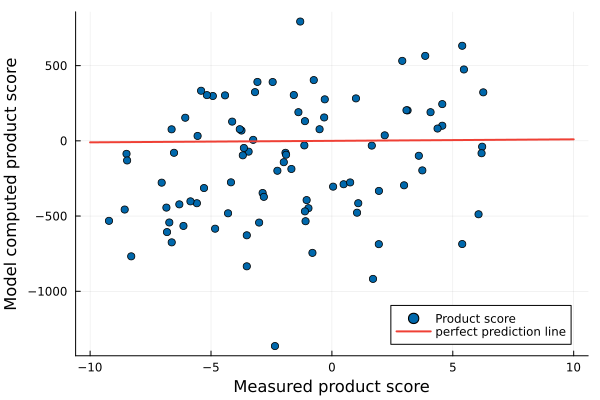

In [30]:
scatter(y_train,ŷ_train,label="Product score",c=colorant"#0068AC")
#scatter(y_test,ŷ_test,label="Product score",c=colorant"#0068AC")
plot!(xy_line,xy_line,lw=2, label="perfect prediction line", c=colorant"#EF4035");
xlabel!("Measured product score", fontsize=18)
ylabel!("Model computed product score", fontsize=18)

## Expected value of the parameters $\beta$ with regularization
We can treat the `underdetermined` case as a regularization problem. If we use `ridge` regularization, i.e., we add a $||\,\beta\,||_{2}^{2}$ term to the objective function:
$$
\begin{equation*}
\hat{\mathbf{\beta}} = \arg\min_{\mathbf{\beta}} ||~\mathbf{y} - \mathbf{X}\cdot\mathbf{\beta}~||^{2}_{2} + \lambda\cdot{||\,\beta\,||_{2}^{2}}
\end{equation*}
$$

where $\lambda\leq{0}$ is called a `regularization` parameter. This problem has an analytical solution of the form:
\begin{equation*}
\hat{\mathbf{\beta}} = \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{y} - \left(\mathbf{X}^{T}\mathbf{X}+\lambda\cdot\mathbf{I}\right)^{-1}\mathbf{X}^{T}\mathbf{\epsilon}
\end{equation*}
The __expectation__ removes the error term. Let's set a value for the regularization parameter $\lambda\geq{0}$

In [31]:
λ = 10.0;
IM = diagm(ones(7200));

Now, solve for the __expected value__ of the unknown parameter vector $\beta$ for the regularized problem. Store the predicted output values from the training data in the `ŷ_train_reg` variable:

In [32]:
β̂_reg = inv(transpose(X_train)*X_train + λ*IM)*transpose(X_train)*y_train;
ŷ_train_reg = X_train*β̂_reg;

### Check: What is the `distance` between the trained and estimated score array for the regularized case?
Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_train` output and calculated output `X_train*β̂_reg` values. We store this in the `δ_reg_train` variable. 
* The larger the `δ_reg_train`, the __worse__ the model is learning the data. Thus, a large value of $\delta_{\star}$ is bad.

In [33]:
δ_reg_train = norm(y_train - ŷ_train_reg)

0.002759118296108695

Let's compute the `ŷ_test_reg` values using `X_test` and the `β̂_reg` parameters. Remember: the model has never seen these values of the data matrix $\mathbf{X}$; thus, this is a pure _out of sample_ prediction:

In [11]:
ŷ_test_reg = X_test*β̂_reg
xy_line = -10:0.01:10 |> collect;

`Unhide` the code block below to see how we plot the measured and predicted product scores:

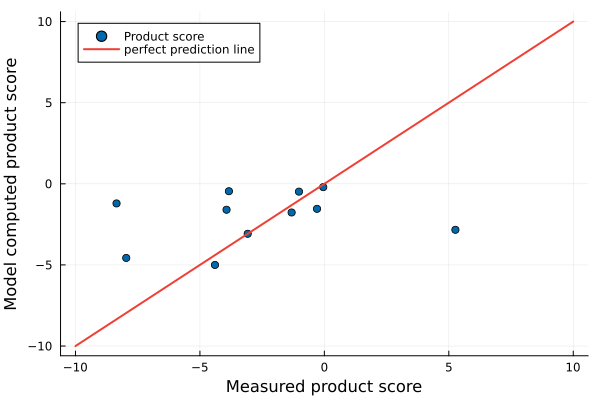

In [35]:
#scatter(y_train,ŷ_train_reg, xlim=[-10.0,10.0],ylim=[-10,10],label="Product score",c=colorant"#0068AC")
scatter(y_test,ŷ_test_reg,label="Product score",c=colorant"#0068AC")
plot!(xy_line,xy_line,lw=2, label="perfect prediction line", c=colorant"#EF4035");
xlabel!("Measured product score", fontsize=18)
ylabel!("Model computed product score", fontsize=18)

#### Check: What is the `distance` between the predicted and test outputs?
Let's use the [norm function exported by the LinearAlgebra package](https://docs.julialang.org/en/v1/stdlib/LinearAlgebra/#LinearAlgebra.norm) to compute the `distance` between the observed `y_test` output and predicted output `X_test*β̂_reg` values. We store this in the `δ_reg_test` variable. 
* What does it mean when `δ_reg_test`$\gg$`δ_reg_train`? Does the model generalize?

In [20]:
δ_reg_test = norm(y_test - ŷ_test_reg)

12.139838189973132

Hmmmm. Not great.